## Train & Validation Losses

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = "wae"
dataset = "celeba"
run = 4

losses = np.load(f'figs_{model}_{dataset}/run_{run:04d}/losses.npy')
val_losses = np.load(f'figs_{model}_{dataset}/run_{run:04d}/val_losses.npy')

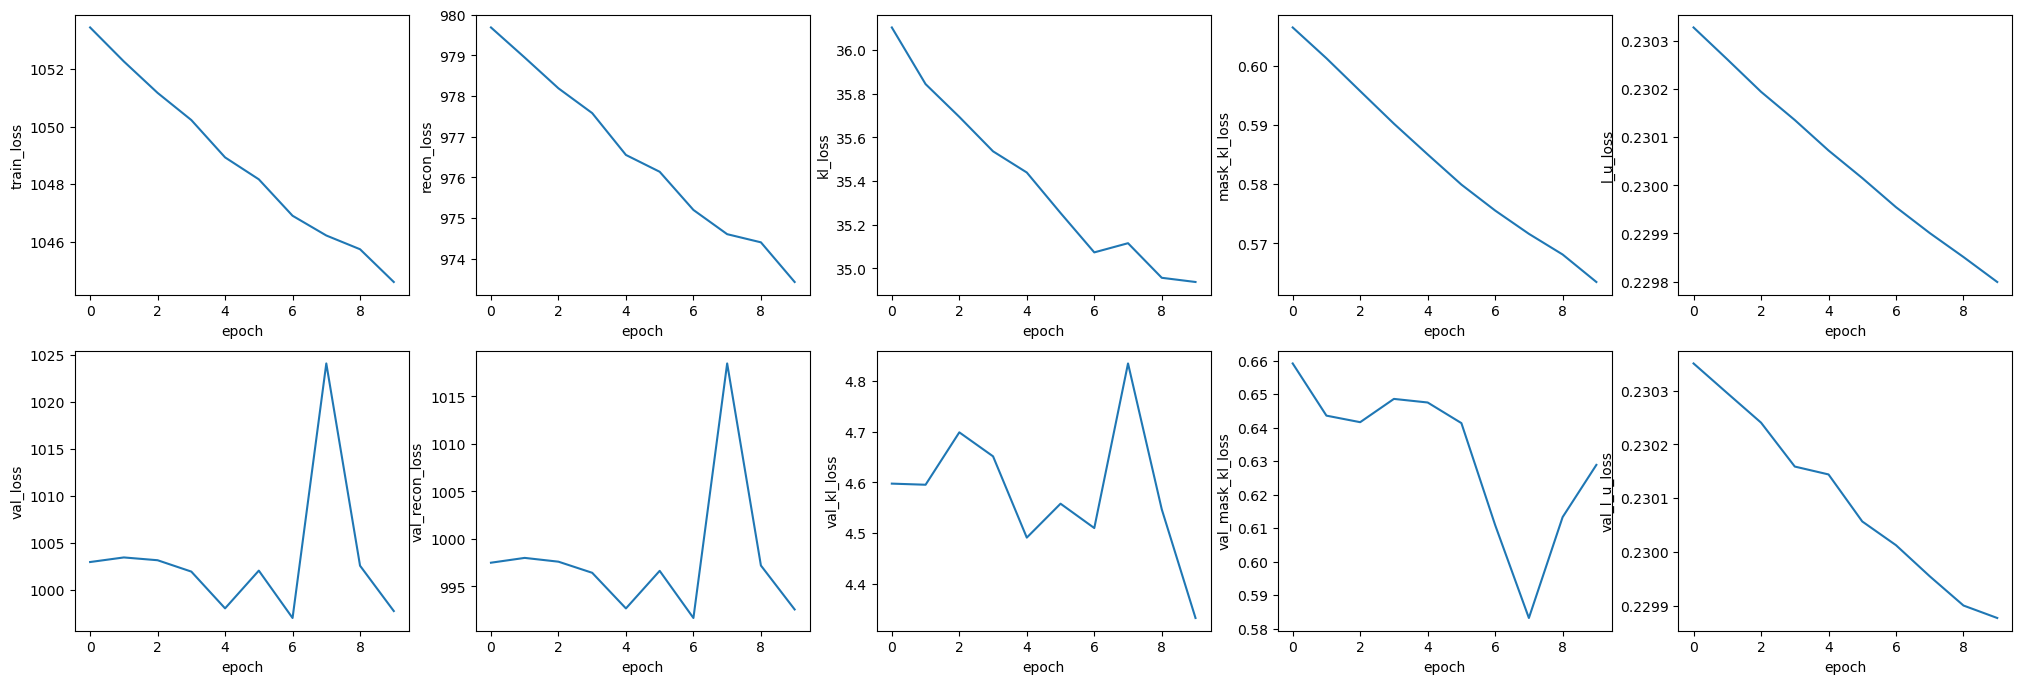

In [3]:
plt.figure(figsize=(25,8))

plt.subplot(251)
plt.plot(losses[10:, 0])
plt.xlabel('epoch')
plt.ylabel('train_loss')

plt.subplot(252)
plt.plot(losses[10:, 4])
plt.xlabel('epoch')
plt.ylabel('recon_loss')

plt.subplot(253)
plt.plot(losses[10:, 1])
plt.xlabel('epoch')
plt.ylabel('kl_loss')

plt.subplot(254)
plt.plot(losses[10:, 2])
plt.xlabel('epoch')
plt.ylabel('mask_kl_loss')

plt.subplot(255)
plt.plot(losses[10:, 3])
plt.xlabel('epoch')
plt.ylabel('l_u_loss')

plt.subplot(256)
plt.plot(val_losses[10:, 0])
plt.xlabel('epoch')
plt.ylabel('val_loss')

plt.subplot(257)
plt.plot(val_losses[10:, 4])
plt.xlabel('epoch')
plt.ylabel('val_recon_loss')

plt.subplot(258)
plt.plot(val_losses[10:, 1])
plt.xlabel('epoch')
plt.ylabel('val_kl_loss')

plt.subplot(259)
plt.plot(val_losses[10:, 2])
plt.xlabel('epoch')
plt.ylabel('val_mask_kl_loss')

plt.subplot(2,5,10)
plt.plot(val_losses[10:, 3])
plt.xlabel('epoch')
plt.ylabel('val_l_u_loss')

plt.show()

## Inference

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import utils
import codebase.models.mask_vae_celeba as vae
import codebase.models.mask_wae_celeba as wae
from codebase import utils as ut

In [5]:
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")

label_type = 0
checkpoint = 100

layout = [
    ('model={:s}',  'causal' + model),
    ('run={:04d}', run),
    ('type={:d}', label_type),
    ('toy={:s}', "celeba"),   
]

model_name = '_'.join([t.format(v) for (t, v) in layout])
print(model_name)

model=causalwae_run=0004_type=0_toy=celeba


In [6]:
if model.lower() == "vae":
    lvae = vae.CausalVAE(name=model_name, inference = True).to(device)
else:
    lvae = wae.CausalWAE(name=model_name, inference = True).to(device)

ut.load_model_by_name(lvae, checkpoint)

Loaded from checkpoints/model=causalwae_run=0004_type=0_toy=celeba/model-00100.pt


In [7]:
dataset_dir = '/home/hjlee/data/CelebA'
test_set = utils.CelebA(dataset_dir, split=[2], label_type = label_type)

In [8]:
torch.manual_seed(123)
idx_arr = torch.randint(len(test_set), (8,))
idx_arr

tensor([ 6682,  8875, 18534, 11754, 14284, 16466,  6408,  6797])

In [9]:
xx = torch.cat([test_set[idx.item()][0].unsqueeze(0) for idx in idx_arr], dim=0)
ll = torch.cat([test_set[idx.item()][1].unsqueeze(0) for idx in idx_arr], dim=0)
print(xx.shape, ll.shape)

torch.Size([8, 3, 128, 128]) torch.Size([8, 4])


- Male
- Smiling
- Narrow_Eyes
- Mouth_Slightly_Open

In [10]:
lvae.dag.A.T

tensor([[-4.9425e-02,  3.0545e-05,  1.5660e-02, -3.0367e-04],
        [-1.7028e-04, -4.6044e-02,  9.3335e-03, -9.6949e-05],
        [-1.3027e+00, -8.5233e-01, -6.7067e-02, -7.4627e-01],
        [ 1.9880e-04,  2.1845e-04,  7.7231e-03, -4.0752e-02]], device='cuda:0',
       grad_fn=<PermuteBackward>)

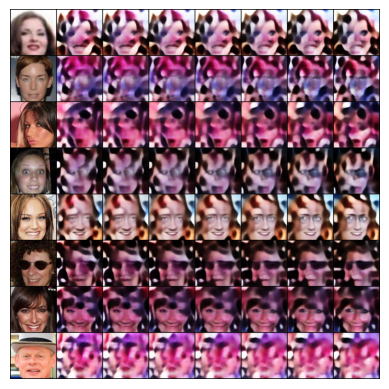

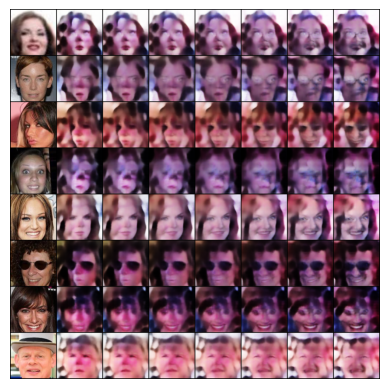

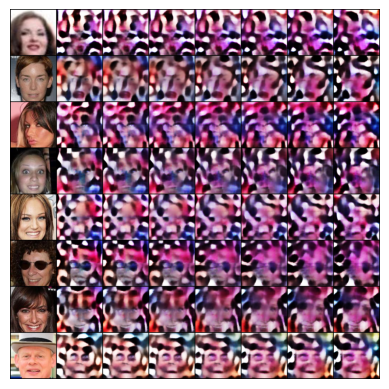

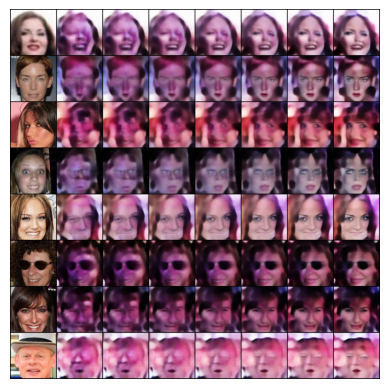

In [11]:
for i in range(4):
    images = torch.zeros((len(idx_arr)*8, 3, 128, 128))
    for k in range(len(xx)):
        images[8*k] = (xx[k]+1.)/2.
    if model.lower() == "vae":
        for j in range(7):
            _, _, _, reconstructed_image, _, _, _, _ = lvae.negative_elbo_bound(xx.to(device), ll.to(device), i, adj=j*.2)
            for k in range(len(xx)):
                images[8*k+(j+1)] = torch.sigmoid(reconstructed_image[k])
    else:
        for j in range(-3, 4):
            _, _, _, reconstructed_image, _, _, _, _ = lvae.negative_elbo_bound(xx.to(device), ll.to(device), mask=i, adj=j*.3)
            for k in range(len(xx)):
                images[8*k+(j+4)] = (reconstructed_image[k]+1.)/2.
    plt.imshow(make_grid(images, nrow=8).permute(1,2,0))
    plt.axis("off")
    # plt.savefig(f'figs_{model}_{dataset}/run_{run:04d}/concept_{i}.png')
    plt.show()

## MIC, TIC 계산

In [12]:
from minepy import MINE

In [13]:
test_loader = DataLoader(test_set, batch_size=500, shuffle=True, num_workers=5)

In [14]:
test_x, test_u = next(iter(test_loader))

In [15]:
_, _, _, _, _, _, decode_m, cp_m = lvae.negative_elbo_bound(test_x.to(device), test_u.to(device))

In [25]:
zz_mic = decode_m.reshape([500, -1]).detach().cpu().numpy()
ll_mic = cp_m.reshape([500, -1]).detach().cpu().numpy()

In [26]:
mine = MINE()

mic_arr, tic_arr = [], []
for kk in range(128):
    mine.compute_score(zz_mic[:, kk], ll_mic[:, kk])
    mic_arr.append(mine.mic())
    tic_arr.append(mine.tic())

In [27]:
mic_arr = np.array(mic_arr)
tic_arr = np.array(tic_arr)
print(f"MIC: {np.mean(mic_arr)}({np.std(mic_arr)})\tTIC: {np.mean(tic_arr)}({np.std(tic_arr)})")

MIC: 0.19923237506962568(0.059329526013514565)	TIC: 7.027181523217344(4.540671423066258)
